# Echo state networks

Vanilla ESN network.

![](../img/rc.jpg)

In [1]:
from ANNarchy import *
clear()
setup(dt=1.0)

ANNarchy 4.6 (4.6.8b) on linux (posix). 


Each neuron in the reservoir follows the following equations:

$$
    \tau \frac{dx(t)}{dt} + x(t) = \sum_\text{input} W^\text{IN} \, r^\text{IN}(t) + g \,  \sum_\text{rec} W^\text{REC} \, r(t) + \xi(t)
$$

$$
    r(t) = \tanh(x(t))
$$

where $\xi(t)$ is some uniform noise.

In [2]:
neuron = Neuron(
    parameters = """
        tau = 30.0 : population # Time constant
        g = 1.0 : population # Scaling
        noise = 0.01
    """,
    equations="""
        tau * dx/dt + x = sum(in) + g * sum(exc) + noise * Uniform(-1, 1)

        r = tanh(x)
    """
)

We take two input neurons and a RC of 500 units.

In [3]:
# Input population
inp = Population(2, Neuron(parameters="r=0.0"))

# Recurrent population
N = 500
pop = Population(N, neuron)

In [4]:
pop.tau = 30.0
pop.g = 1.0
pop.noise = 0.01

Input weights are classically uniformly distributed between -1 and 1.

Recurrent weights are sampled from the normal distribution with mean 0 and variance $g^2 / N$. Here, we put the synaptic scaling $g$ inside the neuron

In [5]:
# Input weights
Wi = Projection(inp, pop, 'in')
Wi.connect_all_to_all(weights=Uniform(-1.0, 1.0))

# Recurrent weights
Wrec = Projection(pop, pop, 'exc')
Wrec.connect_all_to_all(weights=Normal(0., 1/np.sqrt(N)), allow_self_connections=True)

In [6]:
compile()

Compiling... 
OK 


In [7]:
m = Monitor(pop, 'r')

A single trial lasts 3s, with a step input between 100 and 200 ms.

In [8]:
import time

def trial(idx, g):
    "Runs two trials for a given spectral radius."

    # Reset and set spectral radius
    inp.r = 0.0
    pop.x = 0.0
    pop.r = 0.0
    pop.g = g
    
    # Run the trial
    tstart = time.time()
    simulate(100.)
    inp[idx].r = 1.0
    simulate(100.0) # initial stimulation
    inp.r = 0.0
    simulate(2800.)
    print("Took", time.time() - tstart)
    data = m.get('r')
    
    return data

We run two trials successively to look at the chaoticity depending on $g$. 

In [9]:
g = 1.3
data1 = trial(idx=0, g=g)
data2 = trial(idx=0, g=g)

Took 0.9575738906860352
Took 0.9343712329864502


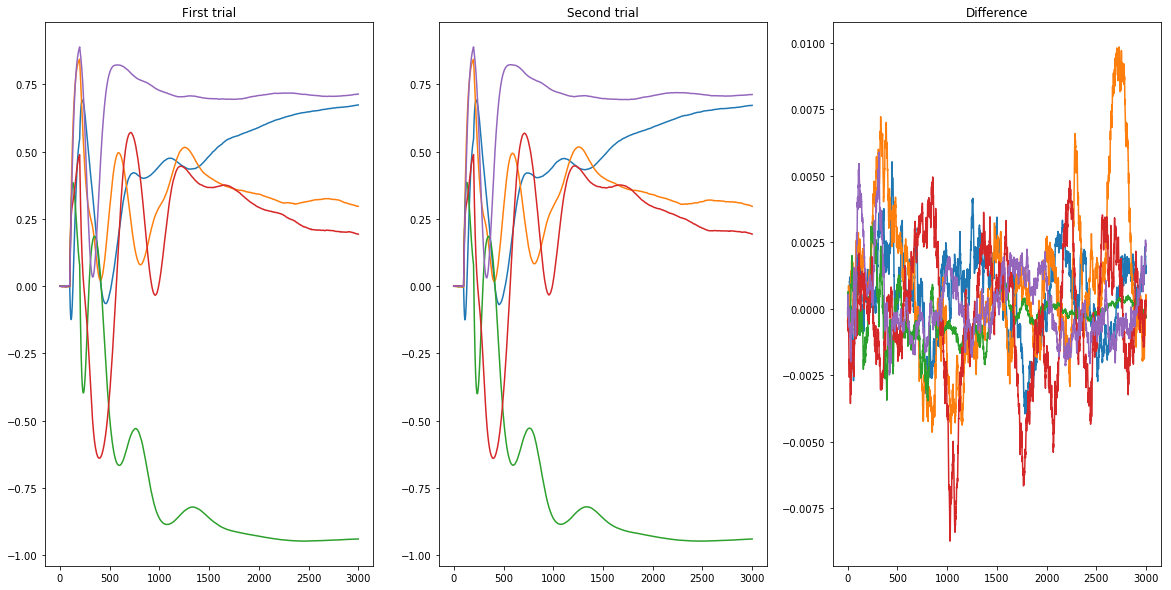

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.title("First trial")
for i in range(5):
    plt.plot(data1[:, i])
plt.subplot(132)
plt.title("Second trial")
for i in range(5):
    plt.plot(data2[:, i])
plt.subplot(133)
plt.title("Difference")
for i in range(5):
    plt.plot(data1[:, i] - data2[:, i])
plt.show()

We can now train the readout neurons to reproduce a step signal after 2 seconds.

For simplicity, we just train a L1-regularized linear regression (LASSO) on the reservoir activity.

In [12]:
target = np.zeros(3000)
target[2000:2500] = 1.0

In [13]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.001, max_iter=10000)
reg.fit(data1, target)
pred = reg.predict(data2)

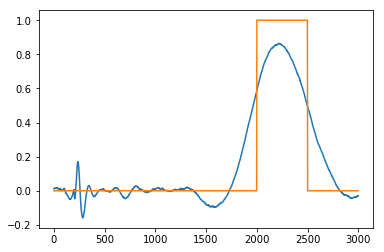

In [14]:
plt.plot(pred)
plt.plot(target)
plt.show()